<a href="https://colab.research.google.com/github/Kryptera-K/SLV-Trend-Strength-Momentum-Pulse-Strategy/blob/main/SLV_D1_%5B'ADX_Upward'_'CCI_Rising'%5D_%5B'Close_Below_ST'_'QQE_Value1_Falling'%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Parameters
# -------------------------
symbol = "SLV"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# ADX Calculation
# -------------------------
def calculate_adx(data, period=14):
    df = data.copy()
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    df['TRn'] = df['TR'].rolling(window=period).sum()
    df['+DMn'] = df['+DM'].rolling(window=period).sum()
    df['-DMn'] = df['-DM'].rolling(window=period).sum()

    df['+DI'] = 100 * (df['+DMn'] / df['TRn'])
    df['-DI'] = 100 * (df['-DMn'] / df['TRn'])

    df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = df['DX'].rolling(window=period).mean()
    return df

def adx_change_direction_upward(df, shifts_para=10):
    return (df['ADX'] > df['ADX'].shift(shifts_para))

df = calculate_adx(df, 14)
df['ADX_Upward'] = adx_change_direction_upward(df)

# -------------------------
# CCI Rising
# -------------------------
def calculate_cci(df, period=14):
    df = df.copy()
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    df['MeanDev'] = df['TP'].rolling(period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df

def cci_rising(df, shifts=5):
    df['CCI_main'] = calculate_cci(df, 14)['CCI']
    return df['CCI_main'] > df['CCI_main'].shift(shifts)

df['CCI_Rising'] = cci_rising(df)

# -------------------------
# SuperTrend (Close_Below_ST)
# -------------------------
def supertrend(df, period=14, multiplier=3):
    hl2 = (df['High'] + df['Low']) / 2
    tr = pd.concat([
        df['High'] - df['Low'],
        abs(df['High'] - df['Close'].shift()),
        abs(df['Low'] - df['Close'].shift())
    ], axis=1).max(axis=1)

    atr = tr.rolling(period).mean()
    upper_basic = hl2 + multiplier * atr
    lower_basic = hl2 - multiplier * atr
    upper_band, lower_band = upper_basic.copy(), lower_basic.copy()
    supertrend = [True]

    for i in range(1, len(df)):
        if df['Close'].iloc[i-1] <= upper_band.iloc[i-1]:
            upper_band.iloc[i] = min(upper_basic.iloc[i], upper_band.iloc[i-1])
        if df['Close'].iloc[i-1] >= lower_band.iloc[i-1]:
            lower_band.iloc[i] = max(lower_basic.iloc[i], lower_band.iloc[i-1])

        if df['Close'].iloc[i] > upper_band.iloc[i-1]:
            supertrend.append(True)
        elif df['Close'].iloc[i] < lower_band.iloc[i-1]:
            supertrend.append(False)
        else:
            supertrend.append(supertrend[-1])

    df['Upper Band'] = upper_band
    df['Lower Band'] = lower_band
    df['Close_Below_ST'] = df['Close'] < df['Lower Band']
    return df

df = supertrend(df)

# -------------------------
# QQE (Value1 Falling)
# -------------------------
rsi_period, qqe_smooth, qqe_factor, qqe_shift = 14, 5, 4.236, 5

delta = df['Close'].diff()
up, down = delta.clip(lower=0), -delta.clip(upper=0)
roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
rsi = 100 - (100 / (1 + roll_up / roll_down))

rsi_ma = rsi.rolling(window=qqe_smooth).mean().fillna(method='bfill')
rsi_delta = rsi_ma.diff().abs().fillna(0)
atr_rsi = rsi_delta.ewm(alpha=1/qqe_smooth, adjust=False).mean()

value1 = rsi_ma.copy()
value2 = pd.Series(index=df.index, dtype=float)
value2.iloc[0] = value1.iloc[0]

for i in range(1, len(df)):
    prev_trail = value2.iloc[i-1]
    prev_value1 = value1.iloc[i-1]
    atr = atr_rsi.iloc[i]
    direction = 1 if prev_value1 > prev_trail else -1
    value2.iloc[i] = prev_trail + direction * qqe_factor * atr

df['QQE_Value1'] = value1
df['QQE_Value1_Falling'] = df['QQE_Value1'] < df['QQE_Value1'].shift(qqe_shift)

# -------------------------
# Entry / Exit Signals
# -------------------------
entry_conditions = ['ADX_Upward', 'CCI_Rising']
exit_conditions  = ['Close_Below_ST', 'QQE_Value1_Falling']

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------
entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()


/tmp/ipython-input-4246624011.py:17: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4246624011.py:116: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Start                                2006-04-28 00:00:00
End                                  2025-09-26 00:00:00
Period                                4885 days 00:00:00
Start Value                                     100000.0
End Value                                 1215349.453305
Total Return [%]                             1115.349453
Benchmark Return [%]                          219.612409
Max Gross Exposure [%]                             100.0
Total Fees Paid                            113628.783338
Max Drawdown [%]                                 53.7549
Max Drawdown Duration                 2255 days 00:00:00
Total Trades                                         107
Total Closed Trades                                  106
Total Open Trades                                      1
Open Trade PnL                             132354.157155
Win Rate [%]                                   47.169811
Best Trade [%]                                 93.553772
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2006-04-28 00:00:00
End                           2025-09-26 00:00:00
Period                         4885 days 00:00:00
Start Value                              100000.0
End Value                           319612.409004
Total Return [%]                       219.612409
Benchmark Return [%]                   219.612409
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        76.186475
Max Drawdown Duration          3624 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      219612.409004
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


In [ ]:
df

,Close,High,Low,Open,Volume,H-L,H-PC,L-PC,TR,+DM,...,ADX_Upward,CCI_main,CCI_Rising,Upper Band,Lower Band,Close_Below_ST,QQE_Value1,QQE_Value1_Falling,entry_signal,exit_signal
Date,,,,,,,,,,,,,,,,,,,,,
2006-04-28,13.812000,13.980000,12.870000,12.900000,23432000,1.110000,NaN,NaN,1.110000,0.000000,...,False,NaN,False,NaN,NaN,False,83.975727,False,False,False
2006-05-01,13.870000,14.179000,13.750000,13.920000,14835000,0.429000,0.367000,0.062000,0.429000,0.199000,...,False,NaN,False,NaN,NaN,False,83.975727,False,False,False
2006-05-02,14.365000,14.400000,14.100000,14.245000,12511000,0.299999,0.530000,0.230000,0.530000,0.221000,...,False,NaN,False,NaN,NaN,False,83.975727,False,False,False
2006-05-03,13.925000,14.464000,13.413000,14.450000,15141000,1.051000,0.099000,0.952000,1.051000,0.000000,...,False,NaN,False,NaN,NaN,False,83.975727,False,False,False
2006-05-04,14.000000,14.287000,13.680000,13.950000,11075000,0.606999,0.362000,0.245000,0.606999,0.000000,...,False,NaN,False,NaN,NaN,False,83.975727,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,40.040001,40.049999,39.340000,39.500000,32055400,0.709999,1.009998,0.299999,1.009998,0.930000,...,True,197.030375,True,39.823571,37.635715,False,68.778590,True,True,False
2025-09-23,39.959999,40.360001,39.790001,40.310001,28492600,0.570000,0.320000,0.250000,0.570000,0.310001,...,True,165.315008,True,42.151428,37.998573,False,68.908362,True,True,False
2025-09-24,39.820000,40.160000,39.639999,40.130001,31533200,0.520000,0.200001,0.320000,0.520000,0.000000,...,True,125.758995,True,41.935713,37.998573,False,70.809785,True,True,False


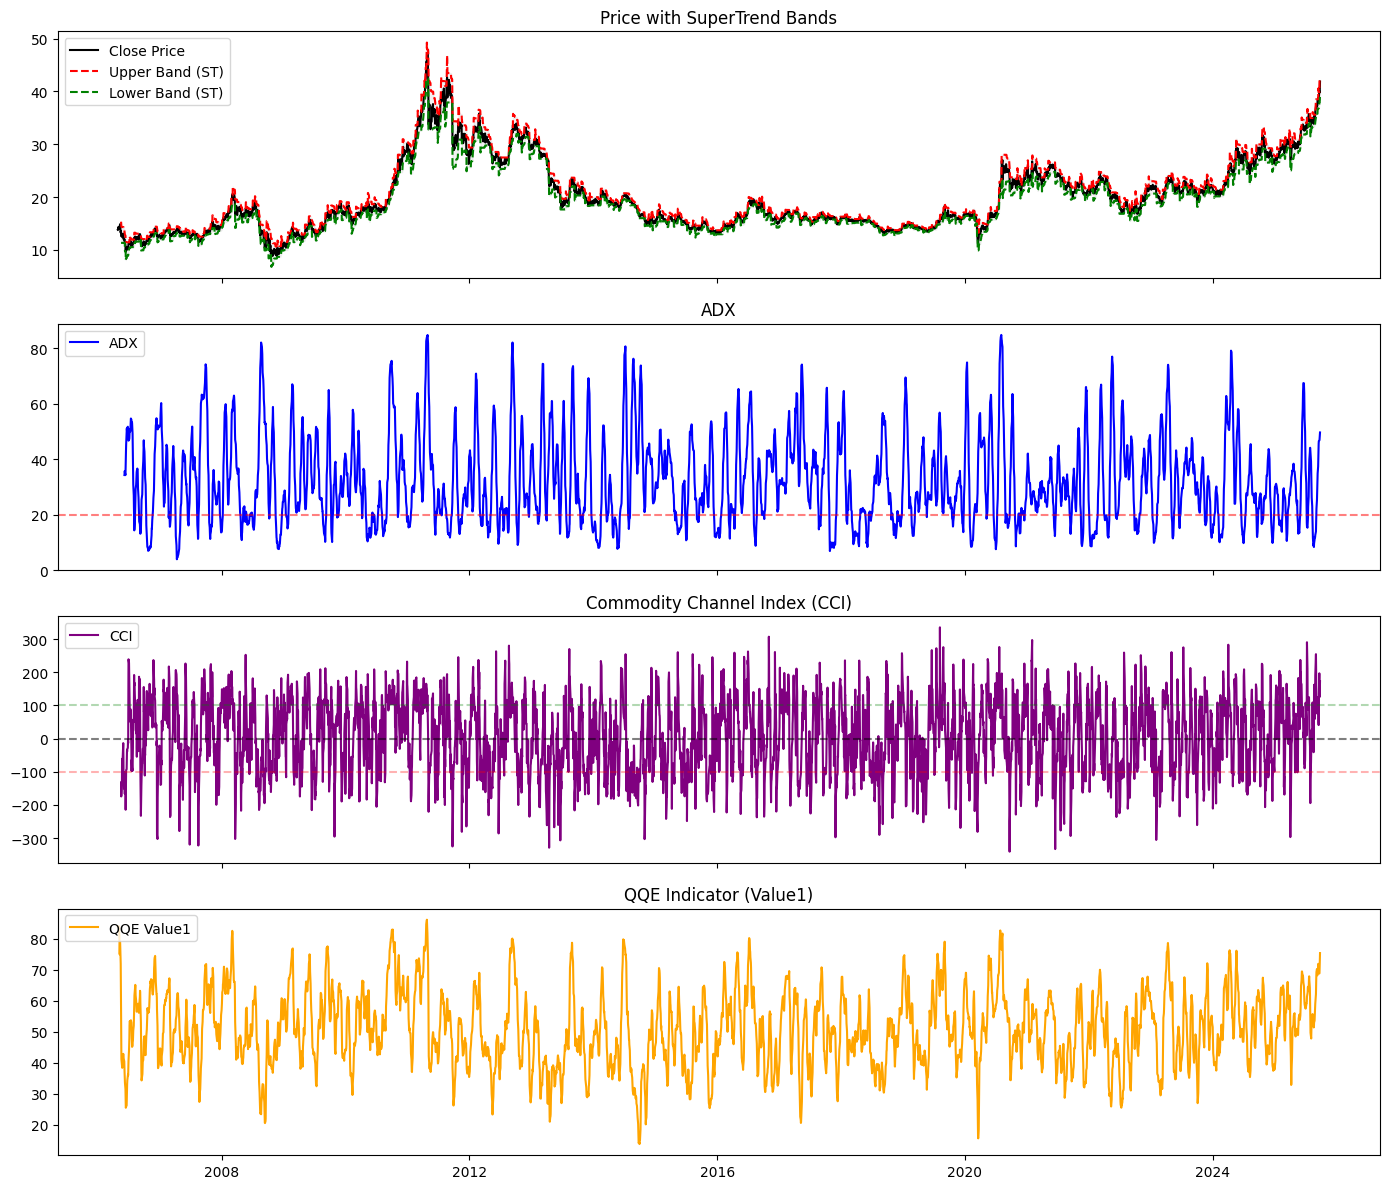

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# Plotting
# -------------------------
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# 1) Price + SuperTrend
axes[0].plot(df.index, df['Close'], label='Close Price', color='black')
axes[0].plot(df.index, df['Upper Band'], label='Upper Band (ST)', color='red', linestyle='--')
axes[0].plot(df.index, df['Lower Band'], label='Lower Band (ST)', color='green', linestyle='--')
axes[0].fill_between(df.index, df['Lower Band'], df['Upper Band'], color='gray', alpha=0.1)
axes[0].set_title("Price with SuperTrend Bands")
axes[0].legend(loc='upper left')

# 2) ADX
axes[1].plot(df.index, df['ADX'], label='ADX', color='blue')
axes[1].axhline(20, color='red', linestyle='--', alpha=0.5)
axes[1].set_title("ADX")
axes[1].legend(loc='upper left')

# 3) CCI
axes[2].plot(df.index, df['CCI_main'], label='CCI', color='purple')
axes[2].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[2].axhline(100, color='green', linestyle='--', alpha=0.3)
axes[2].axhline(-100, color='red', linestyle='--', alpha=0.3)
axes[2].set_title("Commodity Channel Index (CCI)")
axes[2].legend(loc='upper left')

# 4) QQE Value1
axes[3].plot(df.index, df['QQE_Value1'], label='QQE Value1', color='orange')
axes[3].set_title("QQE Indicator (Value1)")
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

# -------------------------
# Parameters
# -------------------------
symbol = "SLV"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df

/tmp/ipython-input-1730202855.py:16: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2006-04-28,13.812000,13.980000,12.870000,12.900000,23432000
2006-05-01,13.870000,14.179000,13.750000,13.920000,14835000
2006-05-02,14.365000,14.400000,14.100000,14.245000,12511000
2006-05-03,13.925000,14.464000,13.413000,14.450000,15141000
2006-05-04,14.000000,14.287000,13.680000,13.950000,11075000
...,...,...,...,...,...
2025-09-22,40.040001,40.049999,39.340000,39.500000,32055400
2025-09-23,39.959999,40.360001,39.790001,40.310001,28492600
2025-09-24,39.820000,40.160000,39.639999,40.130001,31533200
